In [1]:
import numpy as np

from matplotlib import pyplot as plt 
import seaborn as sns

from itertools import product

import cv2

import sys

import os

import re

from PIL import Image 
import PIL

import tensorflow as tf

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall , Accuracy

In [2]:
#function for viewing the image 
def show_img(path,title = 'Default Text'):

    plt.imshow(path,cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(title,{'fontsize': 20}, y = -0.13)
    

In [3]:
input_path = 'Hand_images/user_4_5.jpg'

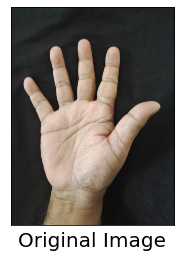

In [4]:
show_img(plt.imread(input_path),'Original Image')

In [5]:
# returning the maximum array among the given array

def maxSize(lst) :
    size = []
    for arr in lst:
        x,y,z = arr.shape
        size.append(x)
    maxpos = size.index(max(size))
    return(lst[maxpos])
        

In [6]:
def diff_find(array):
    j=0
    s1 = []
    while j <len(array):
        e1=array[j][0]
        e2=array[j][1]
        while j<len(array)-1 and (array[j+1][0] - array[j][0]) < 30  :
            e1 = (e1 + array[j+1][0])/2
            e2 = (e2 + array[j+1][1])/2
            j=j+1
        s1.append([e1,e2])
        j=j+1
    return s1
        
    

In [7]:
def find_angle(p1,p2,p3):
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    
    ba = a - b
    bc = c - b
    
    d = np.cross(ba,bc)
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    

    return (np.degrees(angle)) if d <0 else -(np.degrees(angle))

In [8]:
def vally_points(input_path):
    original_img = cv2.imread(input_path)
#     print(original_img.shape)     # (2040, 2040, 3)
    
    
    height ,  width , layer  = original_img.shape

    # zero padding 
    img0 = np.zeros((height+160, width+160 , layer),np.uint8)

    img0[80:-80,80:-80] = original_img

    #convert colours from RGB to gray  
    img = cv2.cvtColor(img0 , cv2.COLOR_RGB2GRAY)

    # smoothing the image
    blur = cv2.GaussianBlur(img,(5,5),0)

    #extract hand by gray scale threshold
    # In Otsu Thresholding, a value of the threshold isn’t chosen but is determined automatically.
    _, th = cv2.threshold(blur , 0 ,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
     #use opencv moments to find out the centre of hand(x_c, y_c)
    M = cv2.moments(th)
    h,w = img.shape
    x_c = M['m10']//M['m00']
    y_c = M['m01']//M['m00']


    # set kernel and use erosion to find hand boundary 
    kernel = np.array([[0,1,0],
                      [1,1,1],
                      [0,1,0]]).astype(np.uint8)
    erosion = cv2.erode(th,kernel, iterations = 1)
    boundary= th - erosion

    cnt, _  = cv2.findContours(boundary,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE )


    img_c = cv2.cvtColor(img , cv2.COLOR_GRAY2BGR)

    # find the longest contour

    cnt_ = maxSize(cnt)


    #draw the contour
    img_cnt = cv2.drawContours(img_c, [cnt_], 0, (255,0,0), 2)


    # find the distance between contour and the centre
    cnt_1 = cnt_.reshape(-1,2)
    left_id = np.argmin(cnt_1.sum(-1))
    cnt_2 = np.concatenate([cnt_1[left_id: , : ], cnt_1[: left_id , : ]])
    dist_c = np. sqrt (np.square(cnt_2-[x_c , y_c]).sum(-1))
    f = np.fft.rfft(dist_c)

    # smoothing the distribution graph
    cutoff = 15
    f_new = np.concatenate([f[: cutoff ], 0*f[cutoff:]])
    dist_c_1 = np.fft.irfft(f_new)

    # find the derivatives and the minimas(valley of hand)
    derivative = np.diff(dist_c_1)
    sign_change = np.diff(np.sign(derivative))/2
    minimas = cnt_2[np.where(sign_change>0)[0]]
    
    minimas = np.array(sorted(minimas, key=lambda x: x[0]))
    return minimas

In [9]:
def roi(input_path):

    original_img = cv2.imread(input_path)
    # show_img(original_img)
    # print(original_img.shape)     # (2040, 2040, 3)

    height ,  width , layer  = original_img.shape

    # zero padding 
    img0 = np.zeros((height+160, width+160 , layer),np.uint8)

    img0[80:-80,80:-80] = original_img


#     plt.figure(figsize=(10,10))
#     plt.subplot(121)
#     show_img(img0 , 'Image Padding')

    #convert colours from RGB to gray  
    img = cv2.cvtColor(img0 , cv2.COLOR_RGB2GRAY)
#     show_img(img, 'Gray Scale Image')



    # smoothing the image
    blur = cv2.GaussianBlur(img,(5,5),0)
#     plt.subplot(122)
#     show_img(blur , 'Smoothing the Image')

    #extract hand by gray scale threshold
    # In Otsu Thresholding, a value of the threshold isn’t chosen but is determined automatically.
    _, th = cv2.threshold(blur , 0 ,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    #use opencv moments to find out the centre of hand(x_c, y_c)
    M = cv2.moments(th)
    h,w = img.shape
    x_c = M['m10']//M['m00']
    y_c = M['m01']//M['m00']
#     plt.figure(figsize=(10,10))
#     plt.subplot(121)
#     plt.plot(x_c , y_c , 'ro' , markersize = 6)
#     show_img(th , 'Centre of Hand')




    # set kernel and use erosion to find hand boundary 
    kernel = np.array([[0,1,0],
                      [1,1,1],
                      [0,1,0]]).astype(np.uint8)
    erosion = cv2.erode(th,kernel, iterations = 1)
    boundary= th - erosion

    cnt, _  = cv2.findContours(boundary,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE )
    img_c = cv2.cvtColor(img , cv2.COLOR_GRAY2BGR)

    # find the longest contour
    cnt_ = maxSize(cnt)


    #draw the contour
    img_cnt = cv2.drawContours(img_c, [cnt_], 0, (255,0,0), 5)


    minimas = vally_points(input_path)
#     plt.figure(figsize = (15,5))
#     plt.subplot(131)
#     plt.plot(minimas[0][0],minimas[0][1], color='lime', marker='o')
#     plt.plot(minimas[1][0],minimas[1][1], color='cyan', marker='o')
    
#     plt.plot(minimas[2][0],minimas[2][1], color='pink', marker='o')
#     plt.plot(minimas[3][0],minimas[3][1], color='maroon', marker='o')
#     plt.plot(minimas[4][0],minimas[4][1], color='orange', marker='o')
#     plt.plot(minimas[5][0],minimas[5][1], color='m', marker='o')
#     show_img(img, 'Valley Points')
    
    minimas = [[i[0] , i[1]] for i in minimas if i[1]<y_c-50]
    
    # extracting the hull(tip) points of hand
    hull = cv2.convexHull(cnt_)
    cv2.drawContours(img_c, [hull], -1, (0, 0, 255), 5)

    hull = [hull[i][0] for i in range(len(hull)) if  hull[i][0][1]<y_c+200]
    hull = np.array(sorted(hull, key=lambda x: x[0]))
    hull = np.array(diff_find(hull))
    hull = np.array(sorted(hull, key=lambda x: x[1]))
    

#     plt.scatter(hull[0,0],hull[0,1],color='b')
#     plt.scatter(x_c,y_c,color='r')
#     show_img(img,'middle finger tip')
    v1=[]
    v2=[]
    for i in range(len(minimas)):
            if (find_angle(minimas[i],[x_c,y_c],hull[0])<0 and find_angle(minimas[i],[x_c,y_c],hull[0])>-65) :
                v1.append(minimas[i])
#                 print(find_angle(minimas[i],[x_c,y_c],hull[0]))   
#                 plt.figure(figsize = (15,5))
#                 plt.plot(minimas[i][0],minimas[i][1], color='pink', marker='o')
#                 plt.scatter(hull[0,0],hull[0,1],color='b')
#                 plt.plot(x_c , y_c , 'ro' , markersize = 10)
#                 plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='#7FFF00')    
#                 plt.plot([x_c,minimas[i][0]],[y_c,minimas[i][1]],color='#FFF68F')
#                 show_img(img, 'Valley Points')

    for i in range(len(minimas)):
            if (find_angle(minimas[i],[x_c,y_c],hull[0])>0 and find_angle(minimas[i],[x_c,y_c],hull[0])<35):
                v2.append(minimas[i])
#                 print(find_angle(minimas[i],[x_c,y_c],hull[0]),minimas[i])    
#                 plt.figure(figsize = (15,5))
#                 plt.plot(minimas[i][0],minimas[i][1], color='pink', marker='o')
#                 plt.scatter(hull[0,0],hull[0,1],color='b')
#                 plt.plot(x_c , y_c , 'ro' , markersize = 10)
#                 plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='#7FFF00')    
#                 plt.plot([x_c,minimas[i][0]],[y_c,minimas[i][1]],color='#FFF68F')
#                 show_img(img, 'Valley Points')
                
    v1 = np.array(sorted(v1, key=lambda x: x[0]))
    v2 = np.array(sorted(v2, key=lambda x: x[0]))
    v1=v1[0]
    v2=v2[0]

    
    
#     plt.figure(figsize = (15,5))
#     plt.plot(v1[0],v1[1], color='pink', marker='o')
#     plt.scatter(hull[0,0],hull[0,1],color='b')
#     plt.plot(x_c , y_c , 'ro' , markersize = 10)
#     plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='#7FFF00')    
#     plt.plot([x_c,v1[0]],[y_c,v1[1]],color='#FFF68F')
#     show_img(img, 'Valley Points')

    
    
#     plt.figure(figsize = (15,5))
#     plt.plot(v2[0],v2[1], color='pink', marker='o')
#     plt.scatter(hull[0,0],hull[0,1],color='b')
#     plt.plot(x_c , y_c , 'ro' , markersize = 10)
#     plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='#7FFF00')    
#     plt.plot([x_c,v2[0]],[y_c,v2[1]],color='#FFF68F')
#     show_img(img, 'Valley Points')

    theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
#     print('The rotation of ROI is {:.02f}\u00b0'.format(theta))
    
    p_ = int(v2[0]), int(v2[1])
    R = cv2.getRotationMatrix2D(tuple(p_), theta, 1)
    img_r = cv2.warpAffine(img0, R, (w,h))
    v1 = (R[ : , : 2] @ v1 + R[ :, -1]).astype(int)
    v2 = (R[ : , : 2] @ v2 + R[ :, -1]).astype(int)
#     plt.figure(figsize = (15,5))
#     plt.subplot(131)
#     plt.plot(v1[0], v1[1], 'ro')
#     plt.plot(v2[0], v2[1], 'bo')
#     show_img( img_r , 'Image Rotation' )
    
    
    ux = v1[0]
    uy = v1[1] + (v2-v1)[0]//3
    lx = v2[0]
    ly = v2[1] + 4*(v2-v1)[0]//3
    cv2.rectangle(img_r, (lx,ly), (ux,uy), (0,255,0), 5)



    roi = img_r[uy:ly , ux:lx]
#     plt.figure(figsize=(5,5))
#     show_img(roi,'Location of ROI')
    return np.array(roi)

In [11]:
def resize_img(img):
    
    # Preprocessing steps - resizing the image to be 128x128
    img = cv2.resize(img,(128,128))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [12]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 35  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [13]:
def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [14]:
def showimage(myimage, figsize=[10,10]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [15]:
hull[:,0,0]

NameError: name 'hull' is not defined

In [16]:
plt.scatter(hull[:,0,0],hull[:,0,1],s=50,edgecolors='k')

NameError: name 'hull' is not defined

In [78]:
def roi1(input_path):

    original_img = plt.imread(input_path)
    plt.figure(figsize=(20,10))
    
    show_img(original_img,'Original Image')
    print(original_img.shape)     # (2040, 2040, 3)

    height ,  width , layer  = original_img.shape

    # zero padding 
    img0 = np.zeros((height+160, width+160 , layer),np.uint8)

    img0[80:-80,80:-80] = original_img


    plt.figure(figsize=(20,10))
    
    show_img(img0 , 'Image Padding')
    plt.show()

    #convert colours from RGB to gray  
    img = cv2.cvtColor(img0 , cv2.COLOR_RGB2GRAY)
    plt.figure(figsize=(20,10))
    
    show_img(img, 'Gray Scale Image')
    plt.show()
    



    # smoothing the image
    blur = cv2.GaussianBlur(img,(5,5),0)
    plt.figure(figsize=(20,10))
    
   
    show_img(blur , 'Smoothing the Image')
    plt.show()
    

    #extract hand by gray scale threshold
    # In Otsu Thresholding, a value of the threshold isn’t chosen but is determined automatically.
    _, th = cv2.threshold(blur , 0 ,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    #use opencv moments to find out the centre of hand(x_c, y_c)
    M = cv2.moments(th)
    h,w = img.shape
    x_c = M['m10']//M['m00']
    y_c = M['m01']//M['m00']
    plt.figure(figsize=(20,10))
   
    plt.plot(x_c , y_c , 'ro' ,markersize = 10)
    show_img(th , 'Centre of Hand')
    plt.show()
    




    # set kernel and use erosion to find hand boundary 
    kernel = np.array([[0,1,0],
                      [1,1,1],
                      [0,1,0]]).astype(np.uint8)
    erosion = cv2.erode(th,kernel, iterations = 1)
    boundary= th - erosion

    cnt, _  = cv2.findContours(boundary,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE )
    img_c = cv2.cvtColor(img , cv2.COLOR_GRAY2BGR)

    # find the longest contour
    cnt_ = maxSize(cnt)


    # draw the contour
    img_cnt = cv2.drawContours(img_c, [cnt_], 0, (255,0,0), 5)


    minimas = vally_points(input_path)
    plt.figure(figsize=(20,10))

    plt.plot(minimas[0][0],minimas[0][1], color='lime', marker='o',markersize = 10)
    plt.plot(minimas[1][0],minimas[1][1], color='cyan', marker='o',markersize = 10)
    
    plt.plot(minimas[2][0],minimas[2][1], color='pink', marker='o',markersize = 10)
    plt.plot(minimas[3][0],minimas[3][1], color='maroon', marker='o',markersize = 10)
    plt.plot(minimas[4][0],minimas[4][1], color='orange', marker='o',markersize = 10)
    plt.plot(minimas[5][0],minimas[5][1], color='m', marker='o',markersize = 10)
    show_img(img, 'All Valley Points')
    plt.show()
    
    minimas = [[i[0] , i[1]] for i in minimas if i[1]<y_c-50]
    
    # extracting the hull(tip) points of hand
    hull = cv2.convexHull(cnt_)
    cv2.drawContours(img_c, [hull], -1, (0, 0, 255), 5)
#     plt.scatter(hull[:,0],hull[:,1],color='b')
    
    plt.figure(figsize = (20,10))
    plt.scatter(hull[:,0,0],hull[:,0,1],color='c',s=60,edgecolors='k')
    show_img(img,'Finger Tips')

    hull = [hull[i][0] for i in range(len(hull)) if  hull[i][0][1]<y_c+200]
    hull = np.array(sorted(hull, key=lambda x: x[0]))
    hull = np.array(diff_find(hull))
    hull = np.array(sorted(hull, key=lambda x: x[1]))
    
    plt.figure(figsize = (20,10))

    plt.scatter(hull[0,0],hull[0,1],color='c',s=70)
    plt.scatter(x_c,y_c,color='r',s=70)
    plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='blue')    
    
    show_img(img,'Middle Finger Tip')
    v1=[]
    v2=[]
    for i in range(len(minimas)):
            if (find_angle(minimas[i],[x_c,y_c],hull[0])<0 and find_angle(minimas[i],[x_c,y_c],hull[0])>-65) :
                v1.append(minimas[i])
#                 print(find_angle(minimas[i],[x_c,y_c],hull[0]))   
#                 plt.figure(figsize = (15,5))
#                 plt.plot(minimas[i][0],minimas[i][1], color='pink', marker='o')
#                 plt.scatter(hull[0,0],hull[0,1],color='b')
#                 plt.plot(x_c , y_c , 'ro' , markersize = 10)
#                 plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='#7FFF00')    
#                 plt.plot([x_c,minimas[i][0]],[y_c,minimas[i][1]],color='#FFF68F')
#                 show_img(img, 'Valley Points')

    for i in range(len(minimas)):
            if (find_angle(minimas[i],[x_c,y_c],hull[0])>0 and find_angle(minimas[i],[x_c,y_c],hull[0])<35):
                v2.append(minimas[i])
#                 print(find_angle(minimas[i],[x_c,y_c],hull[0]),minimas[i])    
#                 plt.figure(figsize = (15,5))
#                 plt.plot(minimas[i][0],minimas[i][1], color='pink', marker='o')
#                 plt.scatter(hull[0,0],hull[0,1],color='b')
#                 plt.plot(x_c , y_c , 'ro' , markersize = 10)
#                 plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='#7FFF00')    
#                 plt.plot([x_c,minimas[i][0]],[y_c,minimas[i][1]],color='#FFF68F')
#                 show_img(img, 'Valley Points')
                
    v1 = np.array(sorted(v1, key=lambda x: x[0]))
    v2 = np.array(sorted(v2, key=lambda x: x[0]))
    v1=v1[0]
    v2=v2[0]

    
    
    plt.figure(figsize = (20,10))
    plt.plot(v1[0],v1[1], color='orange', marker='o',markersize = 10)
    plt.scatter(hull[0,0],hull[0,1],color='c',s=70)
    plt.plot(x_c , y_c , 'ro' , markersize = 10)
    plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='blue')    
    plt.plot([x_c,v1[0]],[y_c,v1[1]],color='m')
    show_img(img, 'Valley Point 1')

    
    
    plt.figure(figsize = (20,10))
    plt.plot(v2[0],v2[1], color='orange', marker='o',markersize = 10)
    plt.scatter(hull[0,0],hull[0,1],color='c',s=70)
    plt.plot(x_c , y_c , 'ro' , markersize = 10)
    plt.plot([x_c,hull[0,0]],[y_c,hull[0,1]],color='blue')    
    plt.plot([x_c,v2[0]],[y_c,v2[1]],color='m')
    show_img(img, 'Valley Point 2')
    
    plt.figure(figsize = (20,10)) 
    plt.scatter(v1[0],v1[1],color='r',s=70)
    plt.scatter(v2[0],v2[1],color='c',s=70)
    show_img(img0, 'Valley Points')
    
    theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
#     print('The rotation of ROI is {:.02f}\u00b0'.format(theta))
    
    p_ = int(v2[0]), int(v2[1])
    R = cv2.getRotationMatrix2D(tuple(p_), theta, 1)
    img_r = cv2.warpAffine(img0, R, (w,h))
    v1 = (R[ : , : 2] @ v1 + R[ :, -1]).astype(int)
    v2 = (R[ : , : 2] @ v2 + R[ :, -1]).astype(int)
    plt.figure(figsize = (20,10))
   
    plt.plot(v1[0], v1[1], 'ro',markersize = 10)
    plt.plot(v2[0], v2[1], 'co',markersize = 10)
    plt.plot([v1[0],v2[0]],[v1[1],v2[1]],color='indigo')    
    
    show_img( img_r , 'Image Rotation' )
    
    
    ux = v1[0]
    uy = v1[1] + (v2-v1)[0]//3
    lx = v2[0]
    ly = v2[1] + 4*(v2-v1)[0]//3
    cv2.rectangle(img_r, (lx,ly), (ux,uy), (0,255,0), 5)



    roi = img_r[uy:ly , ux:lx]
    plt.figure(figsize=(10,10))
    show_img(roi,'Location of ROI')


(4000, 3000, 3)


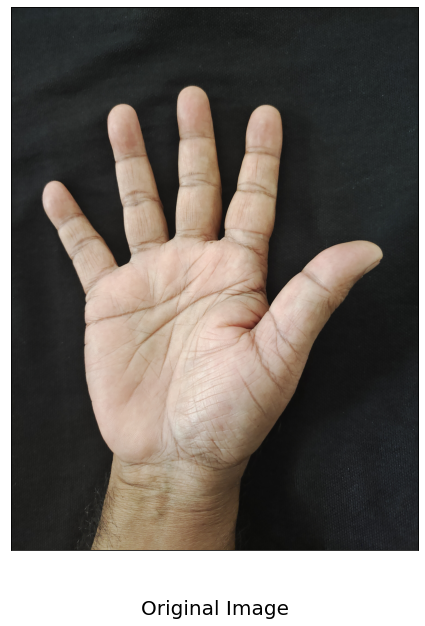

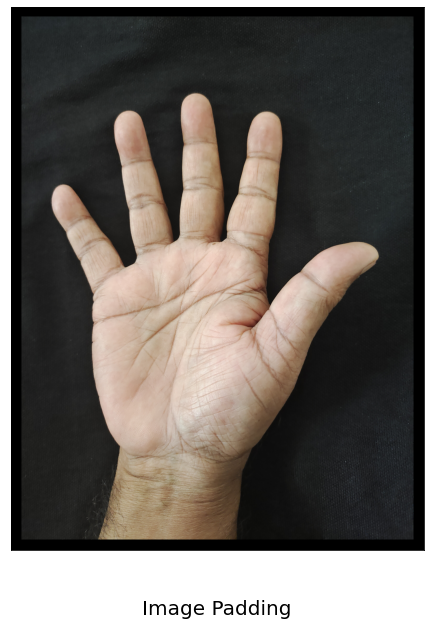

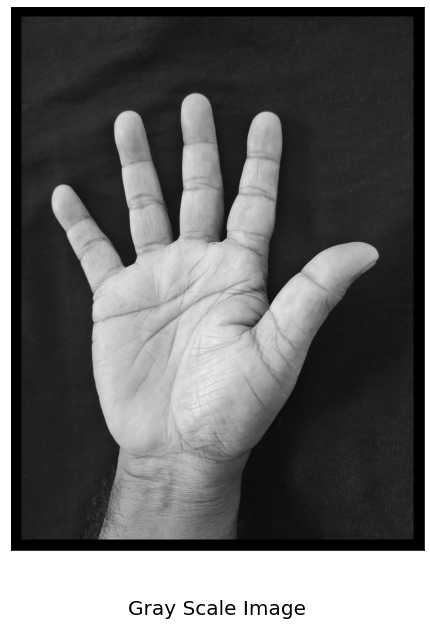

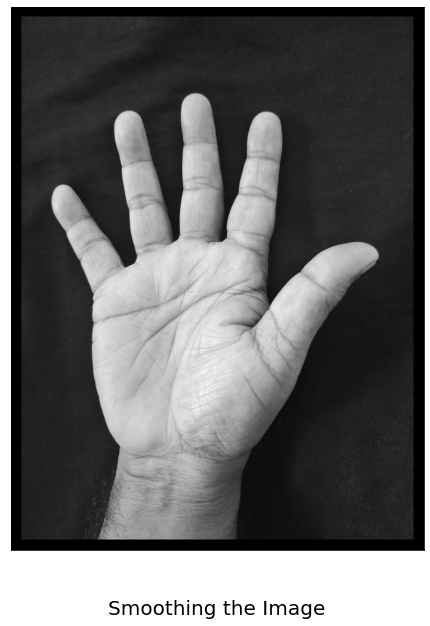

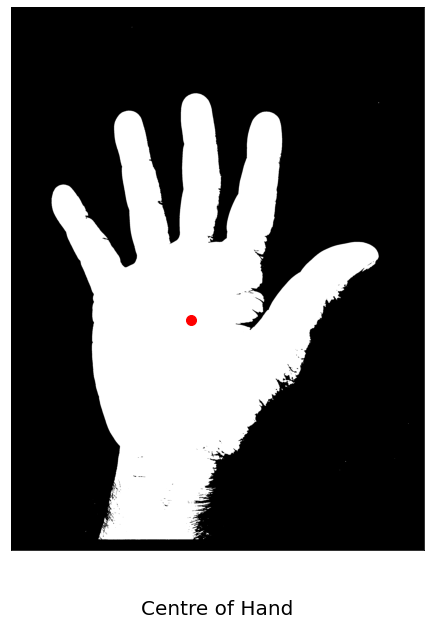

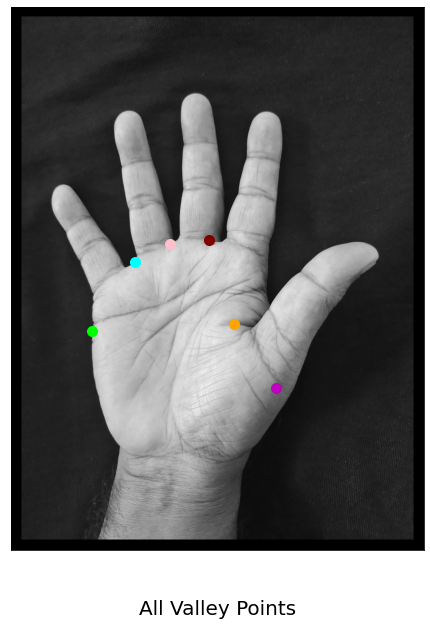

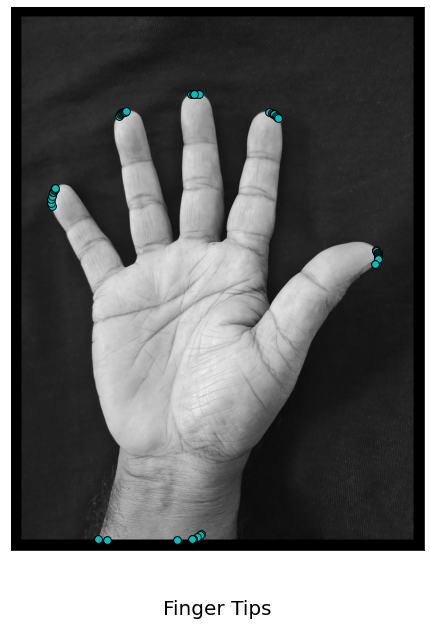

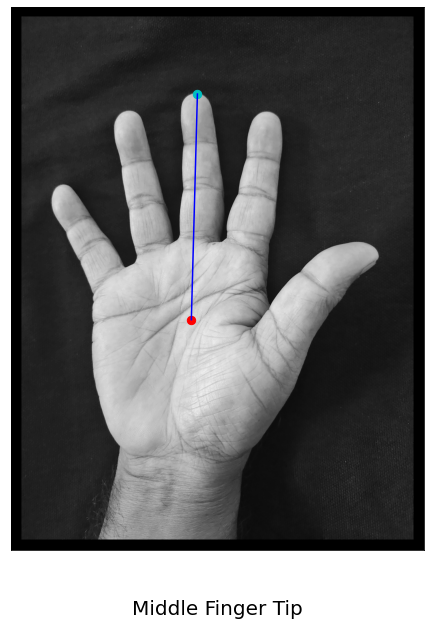

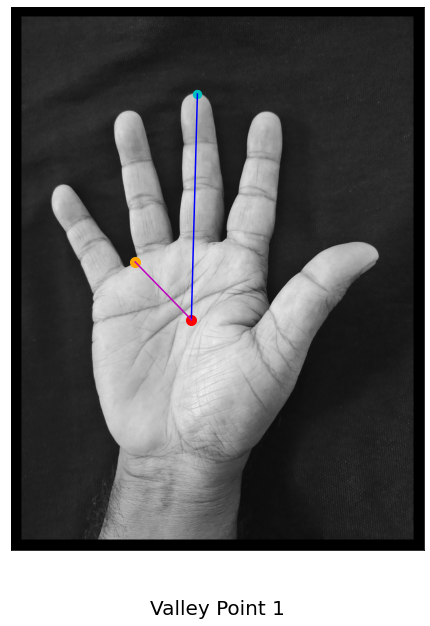

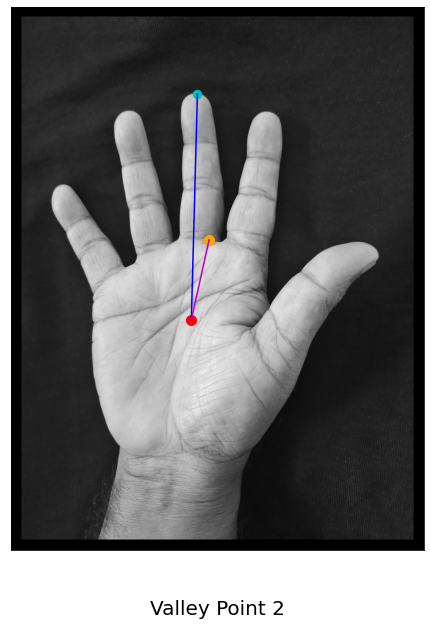

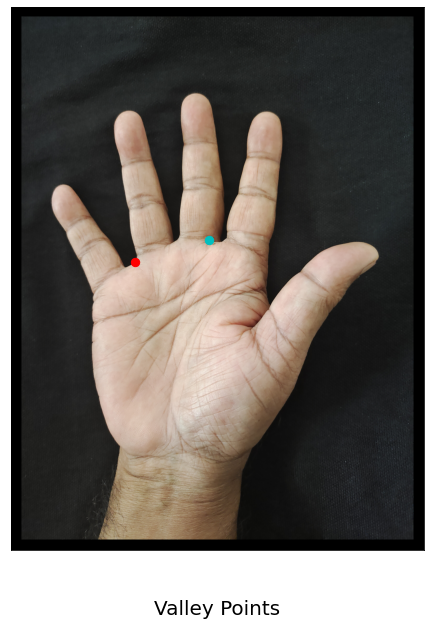

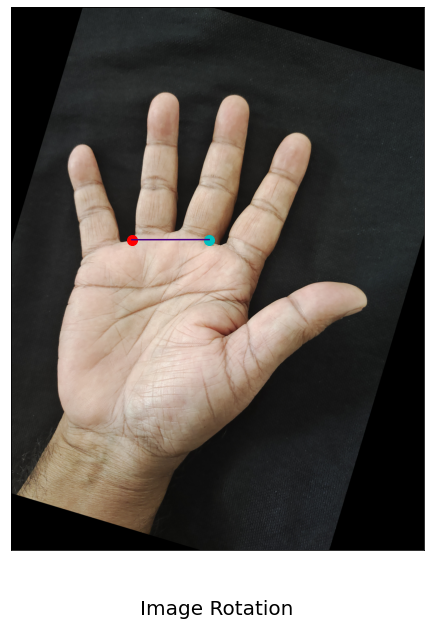

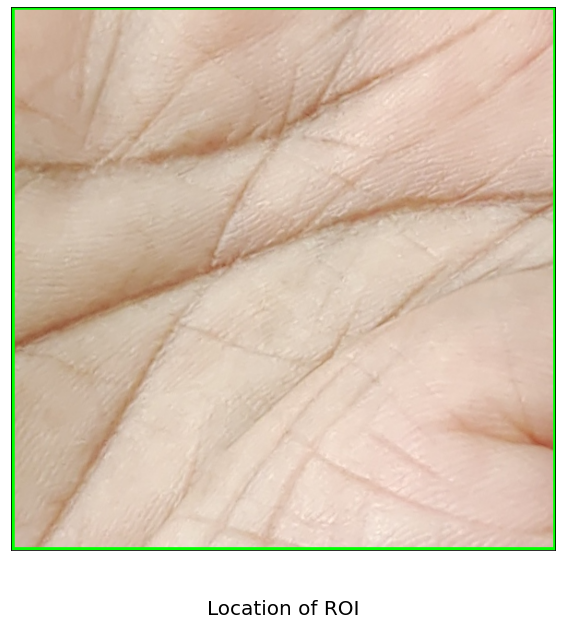

In [79]:
roi1('Hand_images/user_4_5.jpg')


In [18]:
def preprocessing(img):
    # We create our gabor filters, and then apply them to our image
    
    gfilters = create_gaborfilter()
    image_gabor = apply_filter(img, gfilters)

    #Median Filter
    median_filter = cv2.medianBlur(image_gabor,7)

    # cv2.cvtColor is applied over the
    # image input with applied parameters
    # to convert the image in grayscale 
    gray = cv2.cvtColor(median_filter, cv2.COLOR_BGR2GRAY)

    # Using an adaptive thresholging of Gaussian.
    gaussian_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)

    g_img = cv2.cvtColor(gaussian_thresh, cv2.COLOR_GRAY2RGB)
    
    
    return g_img

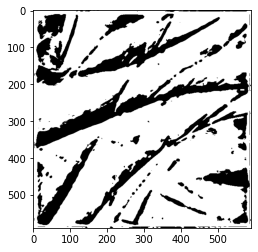

In [83]:
plt.imshow(preprocessing(roi(input_path)))

In [84]:
# # Creating folder 
POS_PATH = os.path.join('user_4','positive')
NEG_PATH = os.path.join('user_4','negative')
ANC_PATH = os.path.join('user_4','anchor')

In [85]:
# os.makedirs('user_4')
# # Folders
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [86]:
count = 0
for i, file in enumerate(os.listdir('Hand_images'), start=1):
    if re.match(r'user_4_\d+.jpg', file) and 0 <= count < 13:
        filena = file.split('.')
        file_path = (os.path.join('Hand_images', file))
        #         print(file_path)
        roi_ex = preprocessing(roi(file_path))
        cv2.imwrite(os.path.join(ANC_PATH, f'roi_{file}'), roi_ex)
        count += 1

    elif re.match(r'user_4_\d+.jpg', file) and 13 <= count < 26:
        file_path = (os.path.join('Hand_images', file))
        #         print(file)
        roi_ex = preprocessing(roi(file_path))
        cv2.imwrite(os.path.join(POS_PATH, f'roi_{file}'), roi_ex)
        count += 1
    else:
        file_path = (os.path.join('Hand_images', file))
#         print(file)
        roi_ex = preprocessing(roi(file_path))
        cv2.imwrite(os.path.join(NEG_PATH, f'roi_{file}'), roi_ex)


In [87]:
# data Augmentation
for file in os.listdir(POS_PATH):
    if re.match(r'roi_user_\d_\d+.jpg', file):
        src = cv2.imread(os.path.join(POS_PATH,file))
        cc_90 = cv2.rotate(src, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(os.path.join(POS_PATH, f'cc_90{file}'), cc_90)

        _180 = cv2.rotate(src, cv2.ROTATE_180)
        cv2.imwrite(os.path.join(POS_PATH, f'_180_{file}'), _180)

        c_90 = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(os.path.join(POS_PATH, f'c_90{file}'), c_90)

for file in os.listdir(NEG_PATH):
    if re.match(r'roi_user_\d_\d+.jpg', file):
        src = cv2.imread(os.path.join(NEG_PATH,file))
        cc_90 = cv2.rotate(src, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(os.path.join(NEG_PATH, f'cc_90{file}'), cc_90)

        _180 = cv2.rotate(src, cv2.ROTATE_180)
        cv2.imwrite(os.path.join(NEG_PATH, f'_180_{file}'), _180)

        c_90 = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(os.path.join(NEG_PATH, f'c_90{file}'), c_90)
        
for file in os.listdir(ANC_PATH):
    if re.match(r'roi_user_\d_\d+.jpg', file):
        src = cv2.imread(os.path.join(ANC_PATH,file))
        
        cc_90 = cv2.rotate(src, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(os.path.join(ANC_PATH, f'cc_90{file}'), cc_90)

        _180 = cv2.rotate(src, cv2.ROTATE_180)
        cv2.imwrite(os.path.join(ANC_PATH, f'_180_{file}'), _180)

        c_90 = cv2.rotate(src, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(os.path.join(ANC_PATH, f'c_90{file}'), c_90)

In [88]:
# # Creating folder 
POS_PATH = os.path.join('user_4','positive')
NEG_PATH = os.path.join('user_4','negative')
ANC_PATH = os.path.join('user_4','anchor')

In [89]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"\*.jpg")
positive = tf.data.Dataset.list_files(POS_PATH+"\*.jpg")
negative = tf.data.Dataset.list_files(NEG_PATH+"\*.jpg")
# positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# data_zip = positives.concatenate(negatives)

In [90]:
negative.as_numpy_iterator().next()

b'user_4\\negative\\roi_user_2_5.jpg'

In [91]:
def rescale(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (128,128))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

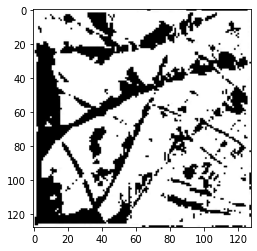

In [92]:
plt.imshow(rescale(anchor.as_numpy_iterator().next()))

In [93]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [94]:
sample = data.as_numpy_iterator().next()

In [95]:
def preprocess_twin(input_img, validation_img, label):
    return(rescale(input_img), rescale(validation_img), label)

In [96]:
res = preprocess_twin(*sample)

1.0

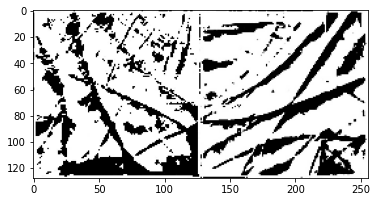

In [97]:
plt.imshow(np.hstack((res[0],res[1])))
res[2]

In [98]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [99]:
sample = data.as_numpy_iterator().next()

In [100]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


In [101]:
train_data.as_numpy_iterator().next()

(array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [9.94222403e-01, 9.94222403e-01, 9.94222403e-01],
          [9.99114096e-01, 9.99114096e-01, 9.99114096e-01]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [9.80681181e-01, 9.80681181e-01, 9.80681181e-01],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

In [102]:
def embedding_model(): 
    inp = Input(shape=(128,128,3), name='input_image')
    
    # First block
    c1 = Conv2D(filters = 64, kernel_size = (6,6), activation='relu', padding = 'same')(inp)
    m1 = MaxPooling2D(pool_size = (2,2) , strides = 2 )(c1)
    
    # Second block
    c2 = Conv2D(filters = 128, kernel_size = (4,4), activation='relu', padding = 'same')(m1)
    m2 = MaxPooling2D(pool_size = (2,2) , strides = 2 )(c2)
    
    # Third block 
    c3 = Conv2D(filters = 256, kernel_size = (3,3), activation='relu' , padding = 'same')(m2)
    m3 = MaxPooling2D(pool_size = (2,2) , strides = 2 )(c3)
    
    # Final embedding block
#     c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(m3)
    d1 = Dense(512, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [103]:
embedding = embedding_model()

In [104]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      6976      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       29

In [105]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [121]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(128,128,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(128,128,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [122]:
siamese_model = make_siamese_model()

In [123]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 512)          33988288    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [124]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-5) # 0.00001

In [125]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [126]:
@tf.function
def train_step(batch):   
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [127]:
def train(data, EPOCHS):
    # Loop through epochs
    # Creating a metric object 
    r = Recall()
    p = Precision()
    acc = Accuracy()
    recall = []
    precision = []
    accuracy = []
    loss_ = []
    genuine=[]
    imposter=[]
    
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
#         # Creating a metric object 
#         r = Recall()
#         p = Precision()
#         acc = Accuracy()
        
        # Loop through each batch
      
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            acc.update_state(batch[2], [1 if prediction >= 0.5 else 0 for prediction in yhat ]) 
            [genuine.append(round(float(prediction),4)) if prediction >= 0.5 else imposter.append(round(float(prediction),4)) for prediction in yhat ]            
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy(),acc.result().numpy())
        recall.append(r.result().numpy())
        precision.append(p.result().numpy())
        accuracy.append(acc.result().numpy())
        loss_.append(loss.numpy())
    return recall , precision , accuracy ,loss_,genuine ,imposter
        
        

In [128]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [129]:
%%notify
recall , precision , accuracy , loss, genuine ,imposter = train(train_data, EPOCHS=100)


 Epoch 1/100
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 2s 248ms/step
0.69575566 0.9166667 0.7173913 0.7808219

 Epoch 2/100
5/5 [==============================] - 1s 190ms/step
0.6664899 0.875 0.76829267 0.8082192

 Epoch 3/100
5/5 [==============================] - 1s 190ms/step
0.66769433 0.90654206 0.81512606 0.8538813

 Epoch 4/100
5/5 [==============================] - 1s 193ms/step
0.63464665 0.9109589 0.84713376 0.8732877

 Epoch 5/100
5/5 [==============================] - 1s 195ms/step
0.64086306 0.9285714 0.87113404 0.8958904

 Epoch 6/100
5/5 [==============================] - 1s 190ms/step
0.6016837 0.94063926 0.8917749 0.913242

 Epoch 7/100
5/5 [==============================] - 1s 190ms/step
0.58399725 0.9486166 0.9056604 0.925636

 Epoch 8/100
5/5 [==============================] - 1s 192ms/step
0.57912207 0.9550173 0.91

5/5 [==============================] - 1s 191ms/step
0.009758171 0.9951201 0.9906577 0.9928692

 Epoch 74/100
5/5 [==============================] - 1s 193ms/step
0.009006005 0.99517983 0.99077153 0.9929656

 Epoch 75/100
5/5 [==============================] - 1s 191ms/step
0.0060335887 0.9952433 0.9908925 0.99305934

 Epoch 76/100
5/5 [==============================] - 1s 190ms/step
0.0077808755 0.99530685 0.99101365 0.9931507

 Epoch 77/100
5/5 [==============================] - 1s 193ms/step
0.006893094 0.9953638 0.9911222 0.99323964

 Epoch 78/100
5/5 [==============================] - 1s 194ms/step
0.0105462335 0.9954306 0.99124956 0.9933263

 Epoch 79/100
5/5 [==============================] - 1s 190ms/step
0.0060529443 0.99549705 0.99137634 0.99341077

 Epoch 80/100
5/5 [==============================] - 1s 191ms/step
0.007473636 0.99554795 0.9914734 0.99349314

 Epoch 81/100
5/5 [==============================] - 1s 192ms/step
0.0058042966 0.9956007 0.991574 0.9935735

 Epoch 8

<IPython.core.display.Javascript object>

In [51]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
# Post processing the results 
[1 if prediction >= 0.5 else 0 for prediction in y_hat ]
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [52]:
y_hat

array([[0.5124617 ],
       [0.51578367],
       [0.500375  ],
       [0.5112455 ],
       [0.5168824 ],
       [0.5133051 ],
       [0.5092223 ],
       [0.5064504 ],
       [0.4993421 ],
       [0.4921784 ],
       [0.5078529 ],
       [0.50703436],
       [0.48374498],
       [0.506692  ],
       [0.51474226],
       [0.4925334 ]], dtype=float32)

In [142]:
style = ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

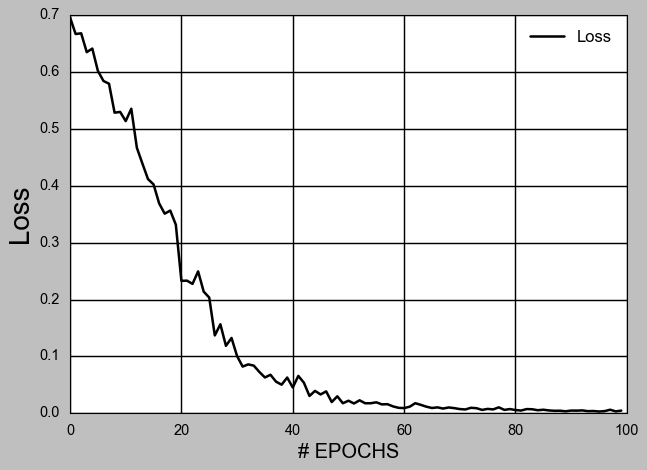

In [154]:

plt.style.use('grayscale')
plt.figure(figsize=(8,6))

plt.plot(loss,label ='Loss',color='k')
# plt.title('Figure 1: Training Loss',fontsize=25,y=-.2)
plt.xlabel('# EPOCHS',fontsize=18)
plt.ylabel('Loss',fontsize=25)
plt.legend(loc=1,fontsize=15)

plt.show()

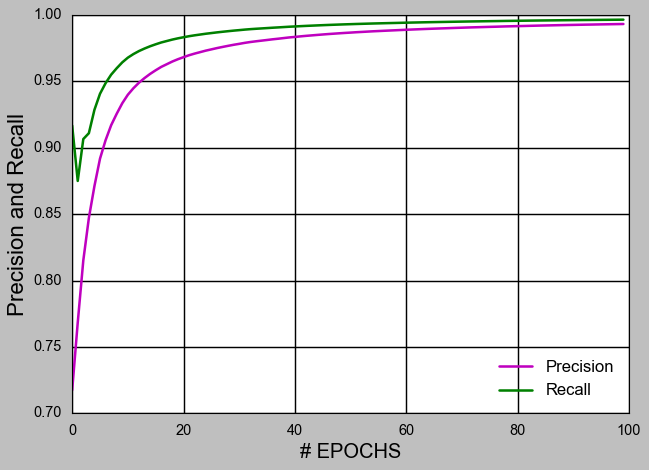

In [155]:
plt.style.use('grayscale')
plt.figure(figsize=(8,6))

plt.plot(precision, label='Precision',color='m')
plt.plot(recall , label='Recall',color='g')
# plt.title('Figure 2: Precision and Recall for Training Data',fontsize=25,y=-.2)
plt.xlabel('# EPOCHS',fontsize=18)
plt.ylabel('Precision and Recall',fontsize=20)
plt.legend(loc=4,fontsize=15)
plt.show()

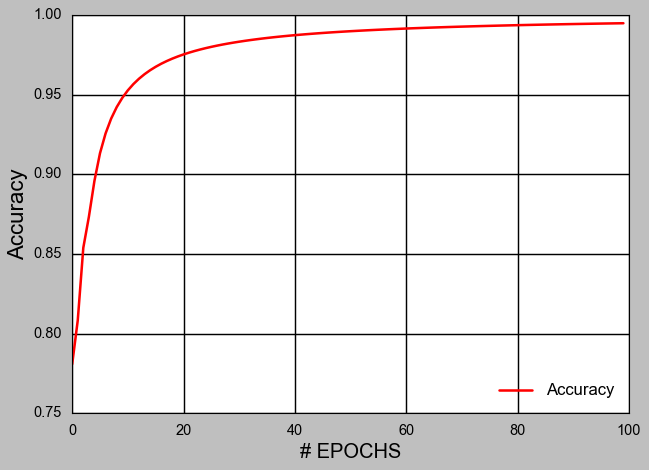

In [156]:
plt.style.use('grayscale')
plt.figure(figsize=(8,6))

plt.plot(accuracy , label ='Accuracy',color='r')
# plt.title('Figure 3: Training Accuracy',fontsize=25,y=-.2)
plt.xlabel('# EPOCHS',fontsize=18)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(loc=4,fontsize=15)

plt.show()

C:\Users\Arpan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Arpan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


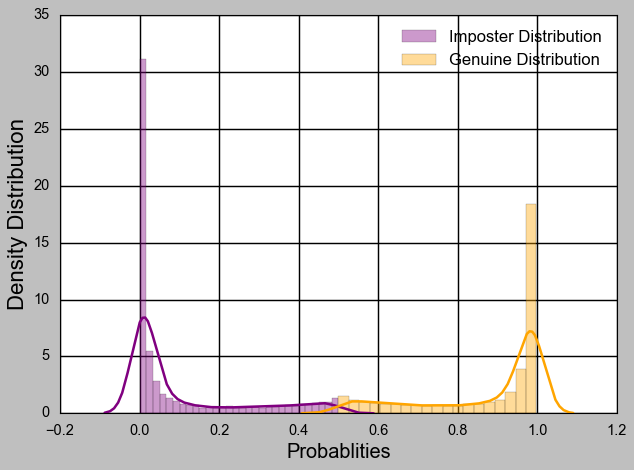

In [158]:
plt.figure(figsize=(8,6))

sns.distplot(imposter,color = 'purple',label='Imposter Distribution')
sns.distplot(genuine,color='orange',label='Genuine Distribution')
# plt.title('Figure 4: Distribution of Training samples',fontsize=25,y=-.2)
plt.xlabel('Probablities',fontsize=18)
plt.ylabel('Density Distribution',fontsize=20)
plt.legend(loc=1,fontsize=15)

plt.show()

In [161]:
def test(data,schuffle):
    # Loop through epochs
    # Creating a metric object 
    r = Recall()
    p = Precision()
    acc = Accuracy()
    recall = []
    precision = []
    accuracy = []
    loss_ = []
    genuine=[]
    imposter=[]
    for epoch in range(1, schuffle+1):
      
        for idx, batch in enumerate(data):
                # Run train step here
                yhat = siamese_model.predict(batch[:2])
                r.update_state(batch[2], yhat)
                p.update_state(batch[2], yhat) 
                acc.update_state(batch[2], [1 if prediction >= 0.5 else 0 for prediction in yhat ]) 
                [genuine.append(round(float(prediction),10)) if prediction >= 0.5 else imposter.append(round(float(prediction),10)) for prediction in yhat ]            

#         print( r.result().numpy(), p.result().numpy(),acc.result().numpy())
        recall.append(r.result().numpy())
        precision.append(p.result().numpy())
        accuracy.append(acc.result().numpy())
    return recall , precision , accuracy ,loss_,genuine ,imposter

In [162]:
recall_ , precision_ , accuracy_ , loss_ , genuine_ ,imposter_ = test(test_data,100)

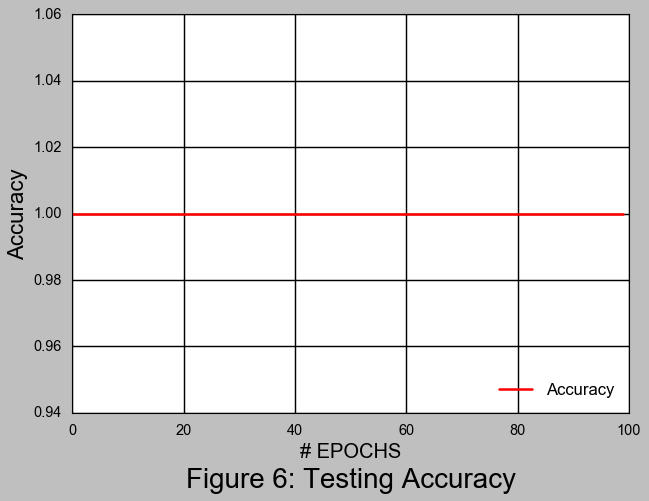

In [163]:
# plt.style.use('seaborn-bright')
plt.figure(figsize=(8,6))

plt.plot(accuracy_ , label ='Accuracy',color='r')
plt.title('Figure 6: Testing Accuracy',fontsize=25,y=-.2)
plt.xlabel('# EPOCHS',fontsize=18)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(loc=4,fontsize=15)

plt.show()

C:\Users\Arpan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Arpan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


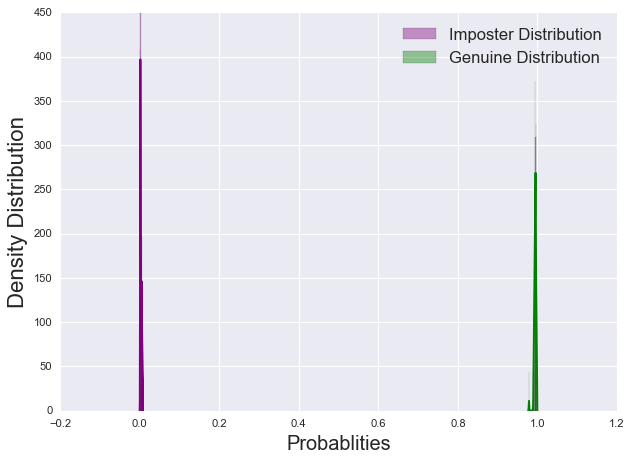

In [170]:
plt.style.use('seaborn-bright')
plt.figure(figsize=(8,6))

sns.distplot(imposter_,color = 'purple',label='Imposter Distribution')
sns.distplot(genuine_,color='g',label='Genuine Distribution')
# plt.title('Figure 5: Distribution of Test Data',fontsize=25,y=-.2)
plt.xlabel('Probablities',fontsize=18)
plt.ylabel('Density Distribution',fontsize=20)
plt.legend(loc=1,fontsize=15)
plt.xlim([-0.2,1.2])

plt.show()